# Tutorial on how to use Directional DIC to measuere displacement from videos
Unidirectional translation identification as introduced in:
Masmeijer T., Habtour E., Zaletelj, K., & Slavič, J., (2024). **Directional DIC method with automatic feature selection**. *MSSP*.
"https://doi.org/10.1016/j.ymssp.2024.112080".

The implementation is based on the Lucas-Kanade method using least-squares iterative optimization with the Zero Normalized
Cross Correlation optimization criterion.

In [1]:
import os
import sys
sys.path.insert(0, os.path.realpath('__file__'))

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pyidi

Load the video

In [ ]:
filename = 'data/data_synthetic.cih'
video = pyidi.VideoReader(filename)

Video info can easily be accessed (info might not be available depending on video file extension)

In [4]:
video.info

{'Date': '2016/08/31',
 'Camera Type': 1,
 'Record Rate(fps)': 1,
 'Shutter Speed(s)': 1.0,
 'Total Frame': 101,
 'Original Total Frame': 101,
 'Start Frame': 0,
 'Image Width': 256,
 'Image Height': 128,
 'Color Type': 'Mono',
 'Color Bit': 16,
 'File Format': 'MRaw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Lower',
 'Comment Text': 'Generated sequence.<br>Modify measurement info in<br>created .cih file if necessary.'}

In [6]:
%matplotlib qt
import matplotlib.animation as animation

def play_video(frame_range = None, interval=30, points = None, ij_counter = (0.65, 0.05)):
    
    """
    Plays the video from the given video object.
    Args:
        frame_range (range object): The range of frames to play.
        interval (int): The interval between frames in milliseconds.
        points (ndarray): Optional tracked points to plot on the video.
        ij_counter (tuple): The position of the frame counter.
    """
    if frame_range is None:
        frame_range = range(0, video.info['Total Frame'])
    fig, ax = plt.subplots()
    im = ax.imshow(video.mraw[frame_range[0]], cmap='gray')
    text = ax.text(ij_counter[0], ij_counter[1], '', transform=ax.transAxes, color='black', ha='right', va='bottom')

    if points is not None:
        pts = ax.plot(points[:,0,1], points[:,0,0], 'r.')

    def update(i):
        im.set_data(video.mraw[i])
        text.set_text(f'Frame {i}')
        if points is not None:
            pts[0].set_data(points[:,i,1], points[:,i,0])
        return im, text

    ani = animation.FuncAnimation(fig, update, frames=frame_range, interval=interval)
    plt.show()
    return ani

ani = play_video(range(1, video.info['Total Frame']))

## `Lucas Kanade` method as a reference

In [7]:
tol = 1e-8
roi_size = (5,5)
idi_lk = pyidi.LucasKanade(video)
idi_lk.configure(reference_image = (0,100), resume_analysis = False, tol=tol, roi_size=roi_size)
reference_image = idi_lk._set_reference_image(video, idi_lk.reference_image)

# Select the highest gradient points
Gi, Gj = np.gradient(reference_image)
G = np.sqrt(Gi**2 + Gj**2)
highest_points = np.argpartition(G.flatten(), -10)[-10:]
arguments = np.unravel_index(highest_points, G.shape)

Visualize the selected points

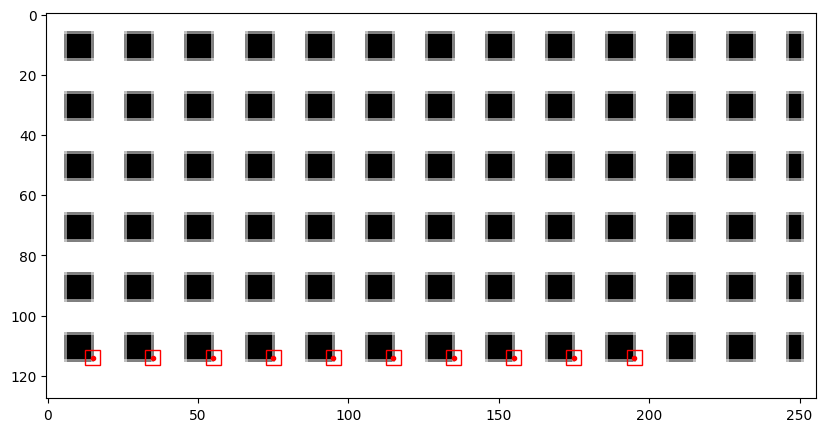

In [8]:
%matplotlib inline
points2d = np.array(arguments).T
idi_lk.set_points(points2d)
idi_lk.show_points()

Compoute displacements

In [9]:
displacementes_2d = idi_lk.get_displacements(processes=2, autosave=False)

Output()

--- Starting new analysis ---
 
Computation start: 2024-12-03 12:48:06.666800


Computation duration: 00:00:2.35


## `Directional - Lucas Kanade` method

In [11]:
idi_dlk = pyidi.DirectionalLucasKanade(video)

Define the direction of motion

In [12]:
tol = 1e-8
roi_size = (5,5)

dij = (0.5, 0.5) # set the direction of motion

idi_dlk.configure(reference_image = (0,100), dij=dij, resume_analysis = False, tol=tol,roi_size=roi_size)

reference_image = idi_dlk._set_reference_image(video, idi_dlk.reference_image)
Gi, Gj = np.gradient(reference_image)
G = np.sqrt(Gi**2 + Gj**2)
highest_points = np.argpartition(G.flatten(), -10)[-10:]
arguments = np.unravel_index(highest_points, G.shape)

d:\git_repos\pyidi\pyidi\methods\_directional_lucas_kanade.py:110: UserWarning: The direction vector d must have a norm of 1. The input vector was normalized.
  warnings.warn('The direction vector d must have a norm of 1. The input vector was normalized.')


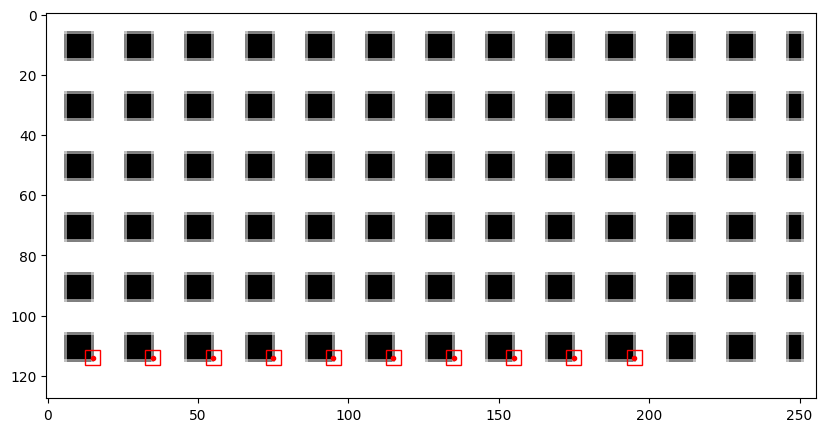

array([0.70710678, 0.70710678])

In [13]:
%matplotlib inline
points1d = np.array(arguments).T
idi_dlk.set_points(points1d)
idi_dlk.show_points()
idi_dlk.dij

Compute displacements

In [14]:
displacements = idi_dlk.get_displacements(processes=2, autosave=False)

Output()

--- Starting new analysis ---
 
Computation start: 2024-12-03 12:49:22.648767


Computation duration: 00:00:2.27


## Comparison

An existing analysis can also be loaded without computation and setting the arguments.

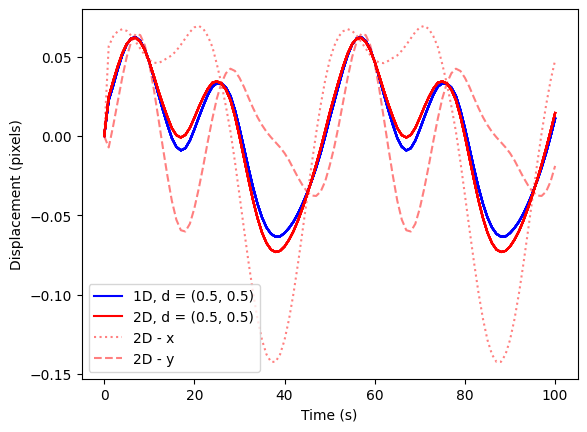

In [15]:
%matplotlib inline
t_vec = np.arange(0, len(displacements[0])) * video.info['Record Rate(fps)']

fig, ax = plt.subplots()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Displacement (pixels)')
for point in displacements:
    ax.plot(t_vec, point[:,0]*dij[0] + point[:,1]*dij[1],'b', label=f'1D, d = {dij}')
for point in displacementes_2d:
    ax.plot(t_vec, point[:,0]*dij[0] + point[:,1]*dij[1], 'r', label=f'2D, d = {dij}')
ax.plot(t_vec, displacementes_2d[0, :,0], 'r:', label = '2D - x', alpha=0.5)
ax.plot(t_vec, displacementes_2d[0, :,1], 'r--', label = '2D - y', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.show()

In [16]:
%matplotlib qt
td2d     = displacementes_2d +  points2d.reshape(len(points2d),1,2)
td1d     = displacements +  points1d.reshape(len(points1d),1,2)
combined_td = np.concatenate((td1d, td2d), axis=0)
ani = play_video(range(1,video.N), points=combined_td)